# Python自动化报表分析

**说明**  
本脚本应当与CSMAR数据库配合，具体使用步骤：
1. 在CSMAR数据库中下载三张财务报表，并将excel文件置于同一文件夹中
2. 进入脚本块**1.1**
    - 写入目标公司代码、放置excel的文件夹路径
    - 可以更改主题色，颜色不宜太亮/太浅
3. 运行全部代码

**饼**  
-   自动加入副坐标轴
-   支持分析行业级数据

**更新日志**  
22-11-29:  
- 更新了一个柱形图宽度算法
- 减少了一些导入包

22-11-26:  
- 现在可以自动加零轴线了  

22-11-25:  
- 整合了四要素图和现金流量图  
  
22-11-24：  
- 新增FormatTicks()用于快速设定y轴格式，取代旧的zoom()  
- 新增Graphing()来快速画图  
- 使用Seaborn来优化取色方法 
- 调整存货/应收账款周转率和天数，选择其一画就好  
  
22-11-18：  
- 优化了一下index逻辑

## 1.   基础配置

In [1]:
#coding=utf-8
import os

from math import exp
from numpy import array, arange
from seaborn import color_palette
from colorsys import rgb_to_hsv, hsv_to_rgb

import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib 设置
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['lines.linewidth'] = '3'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### 1.1. 写入个人配置

In [2]:
# 想要分析的上市公司代码
ID = '603117'

# 在r后面的引号中写入报表文件所在目录
path = r'E:/18082/Documents/9 CodeProjects/sheet'

# 写入想要的主题色
cm = '#9cc3e5'

### 1.2.    生成配色方案

In [4]:
def rgb2hsb(rgb):   # 转为 HSB 色值
    rgb = (int(rgb[1:3], 16), int(rgb[3:5], 16), int(rgb[5:], 16))
    hsv = rgb_to_hsv(rgb[0] / 255, rgb[1] / 255, rgb[2] / 255)
    return hsv

def hsb2rgb(h, s, b):   # 转回 RGB 色系
    rgb = hsv_to_rgb(h, s, b)
    rgb = '#' + hex(int(rgb[0] * 255))[2:] + hex(int(rgb[1] * 255))[2:] + hex(int(rgb[2] * 255))[2:]
    return rgb  # 一个带#号的字符串

# 生成相邻色
def neighborcolor(rgb, num=2, to='+'): 
    hsb = rgb2hsb(rgb)
    nc_hsb = [hsb]

    for i in range(1, num):
        if to == "+":
            h = nc_hsb[-1][0] + 1 / num
            if h > 1:
                h -= 1
        else:
            h = nc_hsb[-1][0] - 1 / num
            if h < 1:
                h += 1
        nc_hsb.append([h, hsb[1], hsb[2]])
    
    nc_rgb = []
    for color in nc_hsb:
        nc_rgb.append(hsb2rgb(color[0], color[1], color[2]))

    return nc_rgb

# 生成递进色
def degreecolor(base, mode='light', num=3):
    return color_palette(mode + ':' + base + '_r', num)

gray = '#d8d8d8'
black = '#000000'

## 2.   数据整理

In [5]:
def DataClean(filename):
    df = pd.read_excel(filename, sheet_name='sheet1', header=None)
    df.loc[1, 1] = '会计期间'
    df.columns = df.values.tolist()[1]
    df = df[df['会计期间'].apply(lambda x: x[5:7] == "12")]
    #df = df.set_index('会计期间')
    df = df[df['报表类型'].isin(['A'])].fillna(value=0)
    return df

os.chdir(path)
path_img = path + '/' + ID
if not os.path.exists(path_img):
    os.makedirs(path_img)

BalanceSheet = DataClean('FS_Combas.xlsx')
IncomeSheet = DataClean('FS_Comins.xlsx')
CashFlowSheet = DataClean('FS_Comscfd.xlsx')
TheSheet = pd.merge(BalanceSheet, IncomeSheet, on=['证券代码','会计期间'])
TheSheet = pd.merge(TheSheet, CashFlowSheet, on=['证券代码','会计期间'])

TheSheet = TheSheet[TheSheet['证券代码'].apply(lambda x: x == ID)]
for i in range(len(TheSheet)):
    TheSheet.iloc[i, 1] = TheSheet.iloc[i, 1][:4]

TheSheet = TheSheet.reset_index(drop=True)

TheSheet['会计期间'] = TheSheet['会计期间'].astype(int)
if TheSheet['会计期间'].min() <= 2018:
    b = min(2018 - TheSheet['会计期间'].min(), len(TheSheet['会计期间']))
    TheSheet.loc[0:b, ['资产减值损失', '信用减值损失']] = -TheSheet.loc[0:b, ['资产减值损失', '信用减值损失']]

TheSheet['会计期间'] = TheSheet['会计期间'].astype(str)

xxx = TheSheet.loc[:, '会计期间']
barwidth = 0.4
x_coor = arange(len(xxx))

e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
e:\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


## 3.   绘图

In [8]:
def FormatTicks(ax, string='{:,}', unit=1):
    y1 = ax.get_yticks()
    y2 = []

    for raw in y1:
        if ',' in string:
            a = int(raw / unit)
        else:
            a = raw / unit
        y2.append(string.format(a))
    
    ax.set_yticks(y1, y2)
# 定义柱和线类
class Bar():
    def __init__(self, num, bottom=0, color='', label=''):
        self.num = num
        self.bottom = bottom
        self.color = color
        self.label = label
class Line():
    def __init__(self, num, color='', label='', ls='-'):
        self.num = num
        self.color = color
        self.label = label
        self.ls = ls

# 画图
def GraphingII(artist, ax, x, width):
    if artist.color == '':
        if isinstance(artist, Bar):
            return (ax.bar(x, artist.num, width, artist.bottom), artist.label)
        elif isinstance(artist, Line):
            return (ax.plot(x, artist.num, ls=artist.ls)[0], artist.label)
    else:
        if isinstance(artist, Bar):
            return (ax.bar(x, artist.num, width, artist.bottom, color=artist.color), artist.label)
        elif isinstance(artist, Line):
            return (ax.plot(x, artist.num, ls=artist.ls, color=artist.color)[0], artist.label)

def GraphingI(list, ax, xlist, hor):
    artists = []
    # 1. 区分Bar 和 Line
    bar_list = []
    line_list = []
    for i in list:
        if isinstance(i, Bar):
            bar_list.append(i)
        elif isinstance(i, Line):
            line_list.append(i)
    bl = len(bar_list)
    # 2. 总宽度和宽度
    if bl == 0:
        width = 0.54
    else:
        width = (0.34 / (1 + exp(-bl + 3)) + 0.5) / bl

    # 3. 设置x 轴
    if hor and bl > 1:
        # 有多个横向的柱子
        xint = arange(len(xlist))
        for i in range(bl):
            if bl % 2 == 0:
                div = (- (bl / 2 - 0.5) + i) * width
            else:
                div = (- (bl / 2 - 1.0) + i) * width
            artists.append(GraphingII(bar_list[i], ax, xint + div, width))
        ax.set_xticks(xint, xlist)
    else:
        for bar in bar_list:
            artists.append(GraphingII(bar, ax, xlist, width))
    # 画折线
    for line in line_list:
        artists.append(GraphingII(line, ax, xlist, width))
    
    artists = array(artists, dtype=object).T.tolist()   
    return artists

def Graphing(major_list, format='{:,}', unit=1, minor_list=[], xlist='', hor=False, **minor_args):
    # Part2: 画图
    fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')
    handles = []
    labels = []
    # 主坐标轴
    major = GraphingI(major_list, ax, xlist, hor)
    handles += major[0]
    labels += major[1]
    ax.margins(x=0.05)

    if 'ma_ylim_l' in minor_args.keys():
        ax.set_ylim(minor_args['ma_ylim_l'])
    if 'ma_ylim_u' in minor_args.keys():
        ax.set_ylim(top=minor_args['ma_ylim_u'])
    if ax.get_ylim()[0] * ax.get_ylim()[1] < 0:
        ax.axhline(color='black', lw=1)

    FormatTicks(ax, string=format, unit=unit)
    # 次坐标轴
    if len(minor_list) >= 1:
        ax1 = ax.twinx()
        minor = GraphingI(minor_list, ax1, xlist, hor)
        handles += minor[0]
        labels += minor[1]
        ax1.spines['right'].set_visible(True)   
        ax1.margins(x=0.05)
        if 'mi_ylim_l' in minor_args.keys():
            ax1.set_ylim(minor_args['mi_ylim_l'])
        if 'mi_ylim_u' in minor_args.keys():
            ax1.set_ylim(top=minor_args['mi_ylim_u'])
        if ax1.get_ylim()[0] * ax1.get_ylim()[1] < 0:
            ax1.axhline(color='gray', lw=1, ls='--')
        
        if 'minor_f' not in minor_args.keys():
            minor_args['minor_f'] = '{:,}'
        if 'minor_u' not in minor_args.keys():
            minor_args['minor_u'] = 1
        FormatTicks(ax1, string=minor_args['minor_f'], unit=minor_args['minor_u'])
    # 图例
    plt.legend(handles, labels)
    # 其他设置
    
    if 'save' in minor_args.keys():
        fig.savefig(minor_args['save'])

### 3.1.    企业经营总览

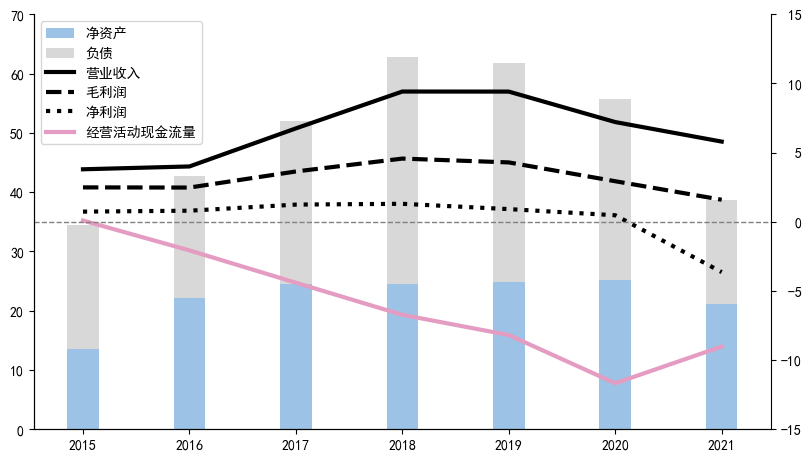

In [9]:
major_list = [
    Bar(TheSheet.loc[:, '所有者权益合计'], label='净资产', color=cm),
    Bar(TheSheet.loc[:, '负债合计'], TheSheet.loc[:, '所有者权益合计'], gray, '负债')
]
minor_list = [
    Line(TheSheet.loc[:, '营业总收入'], black, '营业收入'),
    Line(TheSheet.loc[:, '营业总收入'] - TheSheet.loc[:, '营业成本'], black, '毛利润', ls='--'),
    Line(TheSheet.loc[:, '净利润'], black, '净利润', ls=':'),
    Line(TheSheet.loc[:, '经营活动产生的现金流量净额'], neighborcolor(cm, 3)[1], '经营活动现金流量')
]
Graphing(major_list, unit=1e8, minor_list=minor_list, xlist=xxx, minor_u=1e8, save=path_img + '/1-1', minor_f='{: >3,}')

### 3.2.    偿债能力

#### 偿债能力总览

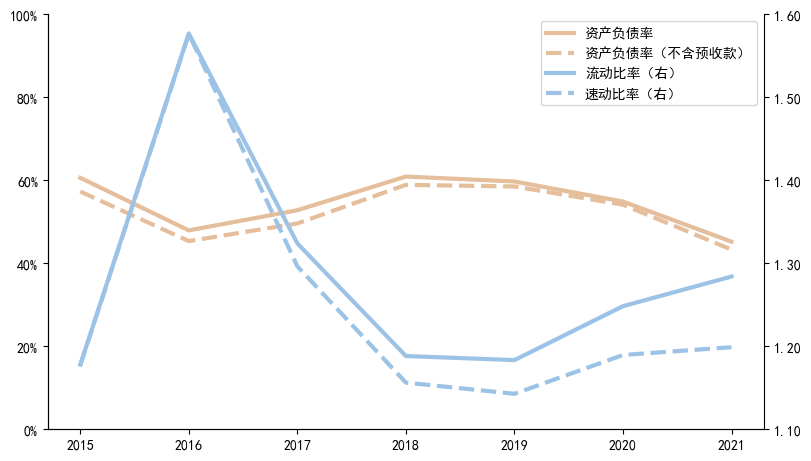

In [10]:
# 流&速动比率与资产负债率
cr = TheSheet.loc[:, '流动资产合计'] / TheSheet.loc[:, '流动负债合计']
qr = (TheSheet.loc[:, '流动资产合计'] - TheSheet.loc[:, '存货净额'])/ TheSheet.loc[:, '流动负债合计']
lev = TheSheet.loc[:, '负债合计'] / TheSheet.loc[:, '资产总计']
lev2 = (TheSheet.loc[:, '负债合计'] - TheSheet.loc[:, '预收款项'] - TheSheet.loc[:, '合同负债']) / TheSheet.loc[:, '资产总计']

Ncolor = neighborcolor(cm, 2, '-')

major_list = [
    Line(lev, Ncolor[1], '资产负债率'),
    Line(lev2, Ncolor[1], '资产负债率（不含预收款）', ls='--'),
]
minor_list = [
    Line(cr, cm, '流动比率（右）'),
    Line(qr, cm, '速动比率（右）', ls='--')
]
Graphing(major_list, '{:.0%}', xlist=xxx, minor_list=minor_list, ma_ylim_l=0, ma_ylim_u=1, save=path_img+'/2-1', minor_f='{:.2f}')

#### 债务的期限结构

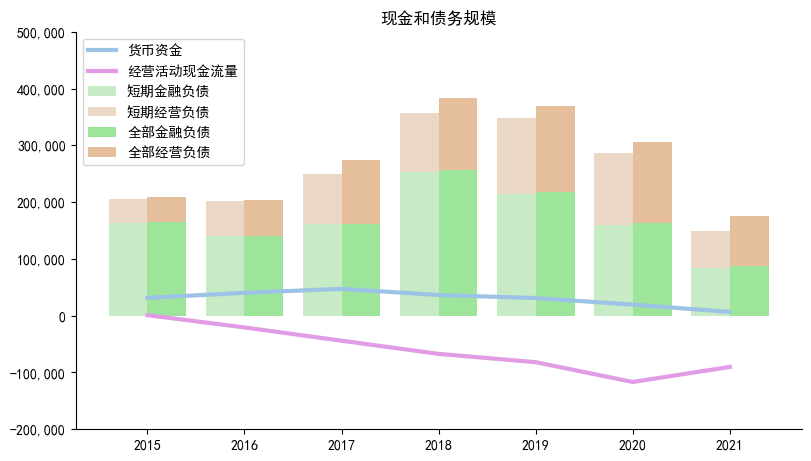

In [13]:
# 现金和债务规模
cash = TheSheet.loc[:, '货币资金']

# 短期金融负债
sfd = TheSheet.loc[:, '短期借款'] + TheSheet.loc[:, '一年内到期的非流动负债'] + TheSheet.loc[:, '应付利息'] + TheSheet.loc[:, '应付股利'] 
# 短期经营负债
sbd = TheSheet.loc[:, '流动负债合计'] - sfd

# 长期金融负债
lfd = TheSheet.loc[:, '长期借款'] + TheSheet.loc[:, '应付债券']
# 长期经营负债
lbd = TheSheet.loc[:, '非流动负债合计'] - lfd

#---------------------------------------------------------------------------#
Ncolor = neighborcolor(cm, 4, '-')
cn1l = degreecolor(Ncolor[1])[1]
cn2l = degreecolor(Ncolor[2])[1]

fig, ax = plt.subplots(figsize=(8, 4.5), layout='constrained')

ax.bar(x_coor - barwidth/2, sfd, barwidth, color=cn1l, label='短期金融负债')
ax.bar(x_coor - barwidth/2, sbd, barwidth, color=cn2l, label='短期经营负债', bottom=sfd)
ax.bar(x_coor + barwidth/2, sfd + lfd, barwidth, color=Ncolor[1], label='全部金融负债')
ax.bar(x_coor + barwidth/2, sbd + lbd, barwidth, color=Ncolor[2], label='全部经营负债', bottom=sfd + lfd)
ax.plot(x_coor, cash, color=cm, lw=3, label='货币资金')
ax.plot(x_coor, TheSheet.loc[:, '经营活动产生的现金流量净额'], color=Ncolor[-1], lw=3, label='经营活动现金流量')

ax.set_xticks(x_coor, xxx)

plt.title('现金和债务规模')
ax.legend()
ax.margins(x=0.05)

FormatTicks(ax, unit=1e4)

fig.savefig(path_img + '/2-2')

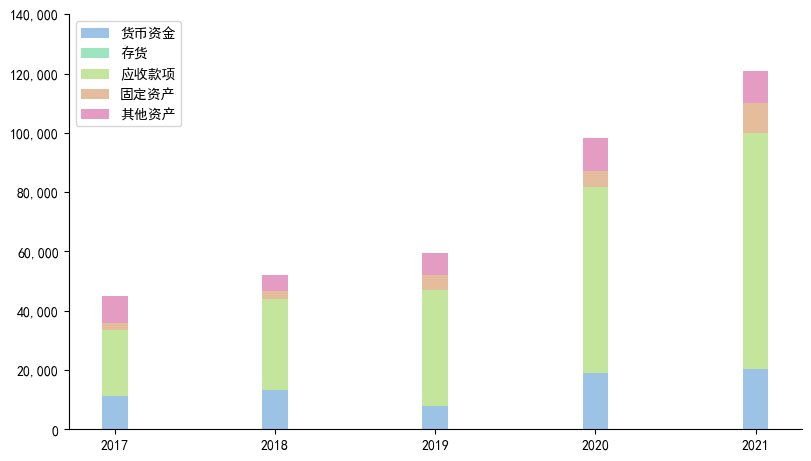

In [ ]:
# 资产结构
ti = TheSheet.loc[:, '营业总收入']
gp = ti - TheSheet.loc[:, '营业成本']   # 毛利润
np = TheSheet.loc[:, '净利润']

gpr = gp / ti # 毛利率
npr = np / ti # 净利率

#---------------------------------------------------------------------------#
#x = TheSheet.loc[:, '会计期间']

Ncolor = neighborcolor(cm, 6, '-')
lightc = degreecolor(cm, num=4)

cash = TheSheet.loc[:, '货币资金']
Inve = TheSheet.loc[:, '存货净额']
FixA = TheSheet.loc[:, '固定资产净额'] + TheSheet.loc[:, '在建工程净额'] + TheSheet.loc[:, '使用权资产']
Accc = TheSheet.loc[:, '应收账款净额'] + TheSheet.loc[:, '其他应收款净额'] + TheSheet.loc[:, '合同资产'] + TheSheet.loc[:, '应收票据净额'] + TheSheet.loc[:, '应收款项融资']


major_list = [
    Bar(cash, 0, Ncolor[0], '货币资金'),
    Bar(Inve, cash, Ncolor[1], '存货'),
    Bar(Accc, cash + Inve, Ncolor[2], '应收款项'),
    Bar(FixA, cash + Inve + Accc, Ncolor[3], '固定资产'),
    Bar(TheSheet.loc[:, '资产总计'] - (cash + Inve + Accc + FixA), cash + Inve + Accc + FixA, Ncolor[4], '其他资产')
    #Line(gp, Ncolor[-1], '毛利润')
]
Graphing(major_list, unit=1e4, xlist=xxx)

### 3.3.    盈利能力

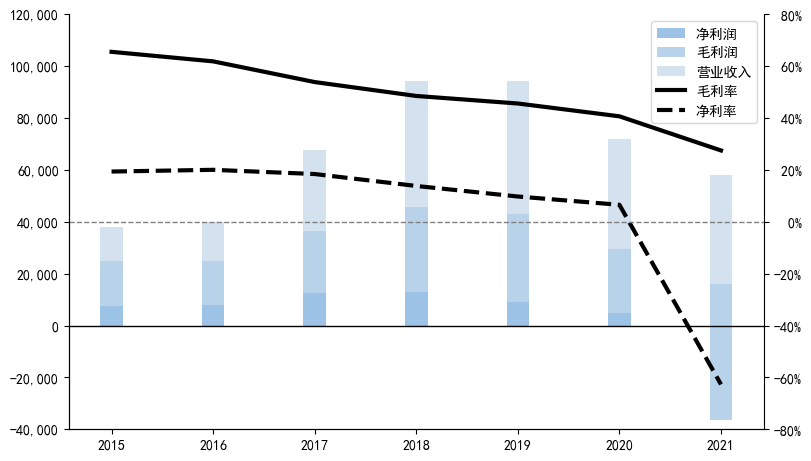

In [14]:
ti = TheSheet.loc[:, '营业总收入']
gp = ti - TheSheet.loc[:, '营业成本']   # 毛利润
np = TheSheet.loc[:, '净利润']

gpr = gp / ti # 毛利率
npr = np / ti # 净利率

#---------------------------------------------------------------------------#
#x = TheSheet.loc[:, '会计期间']

Ncolor = neighborcolor(cm, 4, '-')
lightc = degreecolor(cm, num=4)

major_list = [
    Bar(np, 0, lightc[0], '净利润'),
    Bar(gp - np, np, lightc[1], '毛利润'),
    Bar(ti - gp, gp, lightc[2], '营业收入')
]
minor_list = [
    Line(gpr, black, '毛利率'),
    Line(npr, black, '净利率', ls='--')
]
Graphing(major_list, unit=1e4, xlist=xxx, minor_list=minor_list, minor_f='{: >4.0%}')

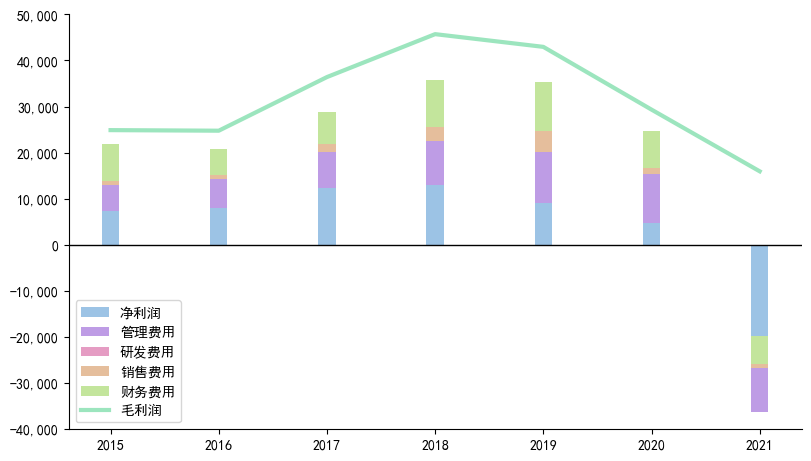

In [15]:
Ncolor = neighborcolor(cm, 6, '+')

c1 = TheSheet.loc[:, '管理费用']
c2 = TheSheet.loc[:, '研发费用']
c3 = TheSheet.loc[:, '销售费用']
c4 = TheSheet.loc[:, '财务费用']

major_list = [
    Bar(np, 0, Ncolor[0], '净利润'),
    Bar(c1, np, Ncolor[1], '管理费用'),
    Bar(c2, np + c1, Ncolor[2], '研发费用'),
    Bar(c3, np + c1 + c2, Ncolor[3], '销售费用'),
    Bar(c4, np + c1 + c2 + c3, Ncolor[4], '财务费用'),
    Line(gp, Ncolor[5], '毛利润')
]
Graphing(major_list, unit=1e4, xlist=xxx)

### 3.4.    周转能力/营运能力

In [16]:
应收 = TheSheet.loc[:, '应收账款净额'] + TheSheet.loc[:, '应收票据净额'] + TheSheet.loc[:, '应收款项融资'] + TheSheet.loc[:, '合同资产'] + TheSheet.loc[:, '其他应收款净额']
应付 = TheSheet.loc[:, '应付票据'] + TheSheet.loc[:, '应付账款'] + TheSheet.loc[:, '其他应付款']

# 应收账款
rtr = TheSheet.loc[:, '营业总收入'] / 应收.rolling(2).mean()
rtd = 360 / rtr

# 存货
itr = TheSheet.loc[:, '营业成本'] / TheSheet.loc[:, '存货净额'].rolling(2).mean()  # 存货周转率
itd = 360 / itr # 存货周转天数

# 占用客户资金（被占用以'-'号填列）：预收 - 应收
occ = (TheSheet.loc[:, '预收款项'] + TheSheet.loc[:, '合同负债']) - 应收
# 占用供应商资金（被占用以'-'号填列）：应付 - 预付
osc = 应付 - TheSheet.loc[:, '预付款项净额']

# 现金周转率1：应收周转率 + 存货周转率 - 应付周转率
ctr1 = rtr + itr - (TheSheet.loc[:, '营业成本'] / 应付.rolling(2).mean())

# 现金周转率2
ctr2 = TheSheet.loc[:, '营业总收入'] / TheSheet.loc[:, '货币资金'].rolling(2).mean()

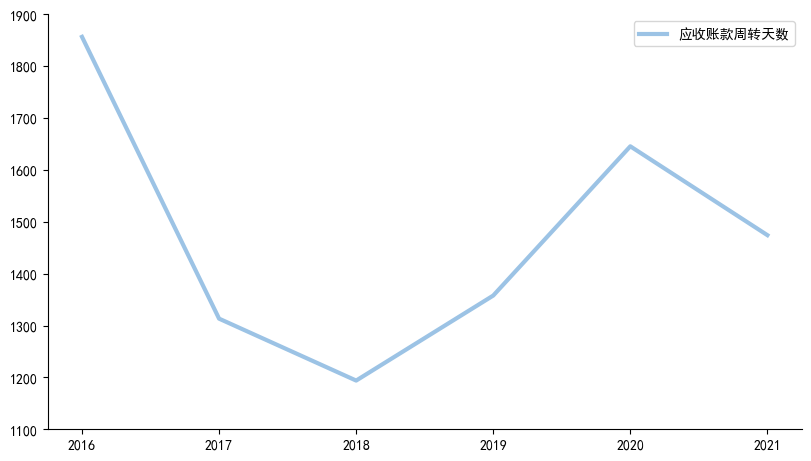

In [17]:
# 周转率 & 周转天数
Ncolor = neighborcolor(cm, 4, '-')

# major_list = [Line(rtr, cm, '应收账款周转率')]; minor_list = [Line(itr, Ncolor[2], '存货周转率（右轴）')];Graphing(major_list, format='{:.2f}', xlist=xxx, minor_list=minor_list, minor_f='{:.2f}')

# major_list = [Line(rtd, cm, '应收账款周转天数')]; minor_list = [Line(itd, Ncolor[2], '存货周转天数（右轴）')];Graphing(major_list, format='{:.0f}', xlist=xxx, minor_list=minor_list, minor_f='{:.0f}')

major_list = [Line(rtd, cm, '应收账款周转天数')]; 
#minor_list = [Line(rtr, Ncolor[2], '应收账款周转率（右轴）')];
Graphing(major_list, format='{:.0f}', xlist=xxx)

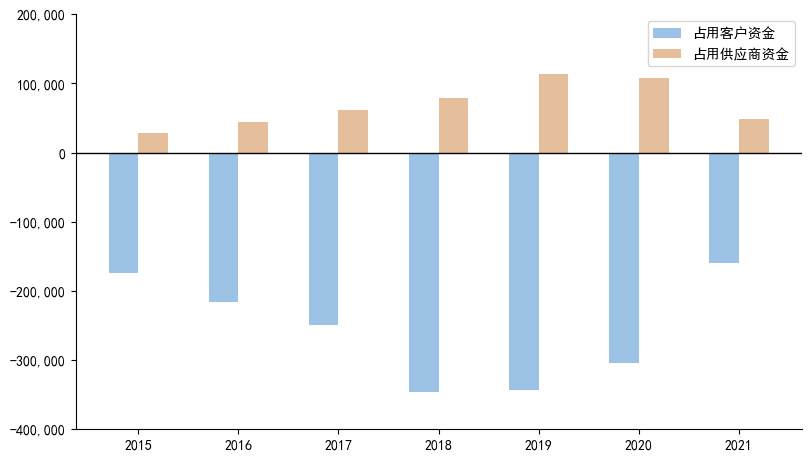

In [18]:
ml = [
    Bar(occ, 0, cm, '占用客户资金'),
    Bar(osc, 0, Ncolor[2], '占用供应商资金'),
]

Graphing(ml, unit=1e4, xlist=xxx, hor=True)